# Comitê AdaBoost

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [48]:
#data = pd.read_csv("../datasets/ds_comite_texto.csv")
#data = pd.read_csv("../datasets/ds_comite_full.csv")
#data = pd.read_csv("../datasets2/ds_comite_texto.csv")
#data = pd.read_csv("../datasets2/ds_comite_full.csv")
#data = pd.read_csv("../datasets/ds_comite_textov2.csv")
#data = pd.read_csv("../datasets/ds_comite_fullv2.csv")
#data = pd.read_csv("../datasets2/ds_comite_textov2.csv")
data = pd.read_csv("../datasets2/ds_comite_fullv2.csv")

data.head()

,id,MAIUSCULAS_x,EXCLAMA_x,ASPAS_x,POL_ABSOLUTO_x,funct,pronoun_x,ppron_x,i_x,we_x,...,anger_y,sad_y,rotulo,ADA,GRD,KNN,NB,RF,RL,SVM
0,53,0.155062,0.0,0.0,0.50,0.597229,0.482377,0.292642,0.210033,0.0,...,0.0,0.0,FALSO,0,0,0,1,0,0,0
1,1136,0.032086,0.0,0.0,0.25,0.391333,0.266170,0.173010,0.000000,0.0,...,0.0,0.0,VERDADE,1,1,1,1,1,0,0
2,695,0.727273,0.0,0.0,0.50,0.291783,0.282805,0.245098,0.000000,0.0,...,0.0,0.0,FALSO,0,0,0,1,0,0,0
3,3312,0.069199,0.0,0.0,625.00,0.510839,0.251148,0.139925,0.000000,0.0,...,0.0,0.0,VERDADE,1,1,1,1,1,1,1
4,1314,0.000000,0.0,0.0,0.50,0.505184,0.248368,0.138376,0.000000,0.0,...,0.0,0.0,VERDADE,1,1,1,1,1,1,1


In [49]:
X = data.drop('id', axis=1)
X = X.drop('rotulo', axis=1)
X = X.drop('ADA', axis=1) #<----
y = data['rotulo']

In [50]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

### SMOTE dataset pq ele é desbalanceado
over = SMOTE(sampling_strategy=1, random_state=109)
under = RandomUnderSampler(sampling_strategy=1, random_state=109)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

print('Original dataset:', Counter(y))

X, y = pipeline.fit_resample(X, y)

print('Resampled dataset:', Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=109)

model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Original dataset: Counter({'VERDADE': 613, 'FALSO': 379})
Resampled dataset: Counter({'FALSO': 613, 'VERDADE': 613})


In [51]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[182   4]
 [  3 179]]
              precision    recall  f1-score   support

       FALSO       0.98      0.98      0.98       186
     VERDADE       0.98      0.98      0.98       182

    accuracy                           0.98       368
   macro avg       0.98      0.98      0.98       368
weighted avg       0.98      0.98      0.98       368



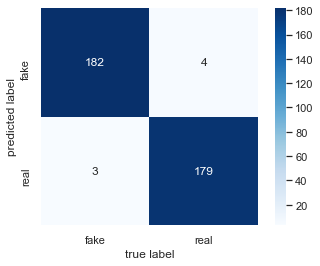

In [52]:
# use seaborn plotting defaults
import seaborn as sns; sns.set()

mat = confusion_matrix(y_test,y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Blues", cbar=True,
            xticklabels=['fake','real'],
            yticklabels=['fake','real'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## Validação Cruzada

In [53]:
from sklearn.model_selection import  StratifiedKFold, KFold, cross_val_score  
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# dfcv = pd.read_csv("datasets/ds_full_validacao_pt.csv")

# Xcv = dfcv.drop('rotulo', axis=1)
# Ycv = dfcv['rotulo']

Xcv = X
Ycv = y

# print('Original dataset:', Counter(Ycv))
# Xcv, Ycv = pipeline.fit_resample(Xcv, Ycv)
# print('Resampled dataset:', Counter(Ycv))


k_folds = StratifiedKFold(n_splits=10, random_state=109, shuffle=True)

scores = cross_val_score(model, Xcv, Ycv, cv=k_folds, scoring='accuracy',n_jobs=-1, verbose=False)
print("Accuracy: %0.4f (+/- %0.4f) "% (scores.mean(), scores.std()))

auc = cross_val_score(model, Xcv, Ycv,  cv=k_folds, scoring = 'roc_auc')
print("AUC: %0.4f (+/- %0.4f) "% (auc.mean(), auc.std()))

#Transforma para 0 e 1
encoder = LabelEncoder()
encoder.fit(Ycv)
encoded_Y = encoder.transform(Ycv)

f1 = cross_val_score(model, Xcv, encoded_Y, cv=k_folds, scoring='f1', n_jobs=-1, verbose=False)
print("F1: %0.4f (+/- %0.4f) "% (f1.mean(), f1.std()))

Accuracy: 0.9787 (+/- 0.0613) 
AUC: 0.9795 (+/- 0.0615) 
F1: 0.9793 (+/- 0.0620) 


## Matriz de Confusão K-Fold

[[600  13]
 [  8 605]]
              precision    recall  f1-score   support

       FALSO       0.99      0.98      0.98       613
     VERDADE       0.98      0.99      0.98       613

    accuracy                           0.98      1226
   macro avg       0.98      0.98      0.98      1226
weighted avg       0.98      0.98      0.98      1226



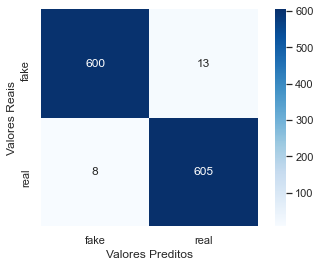

In [47]:
from sklearn.model_selection import cross_val_predict

y_pred_cv = cross_val_predict(model, Xcv, Ycv, cv=k_folds)
mat_cv = confusion_matrix(Ycv, y_pred_cv)

print(mat_cv)
print(classification_report(Ycv, y_pred_cv))

sns.heatmap(mat_cv, square=True, annot=True, fmt='d', cmap="Blues", cbar=True,
            xticklabels=['fake','real'],
            yticklabels=['fake','real'])
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais');

## Curva ROC K-Fold

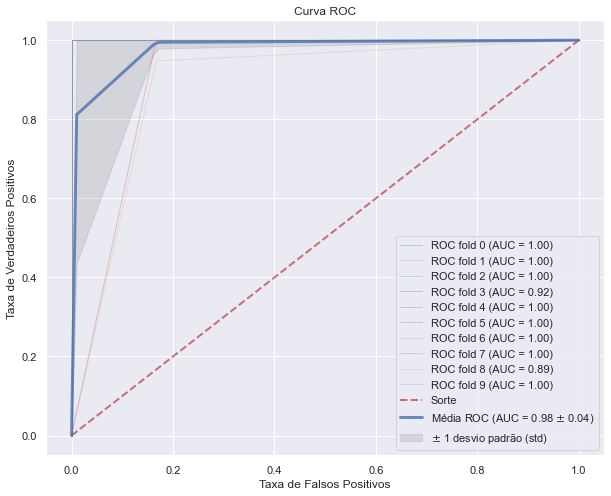

In [10]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

#Trabalha o Dataset Para poder ser printado
Xcv = X
Ycv = y
scaler = MinMaxScaler().fit(Xcv)
Xcv = scaler.transform(Xcv)

encoder = LabelEncoder()
encoder.fit(Ycv)
Ycv = encoder.transform(Ycv)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i,(train, test) in enumerate(k_folds.split(Xcv, Ycv)):
    model.fit(Xcv[train], Ycv[train])
    viz = plot_roc_curve(model, Xcv[test], Ycv[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Sorte', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
       label=r'Média ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
       lw=3, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=.2,
                label=r'$\pm$ 1 desvio padrão (std)')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Curva ROC")
ax.legend(loc=0)
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.show()